In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras import layers
from tensorflow import convert_to_tensor
sns.set_style("whitegrid")

In [62]:
aggregate=pd.read_csv('./aggregate.csv',engine='python')
aggregate.set_index('GEO_ID',inplace=True)
agg_train, agg_test = train_test_split(aggregate,test_size=0.2,shuffle=True,random_state=121) # Split dataset into 80%-20% training and testing, random_state=121 for consistency

#Construct extra features for use in the models
agg_train['unemp_bac']=agg_train['unemp_rate']*agg_train['bac_deg']
agg_train['log_pop']=np.log10(agg_train['total_pop'].apply(lambda x: max(x,0.1)))
agg_train['log_urban_pop']=np.log10((agg_train['urban']*agg_train['total_pop']).apply(lambda x: max(x,0.1)))
for x in agg_train.index:
    agg_train.loc[x,'winner'] = 'D' if agg_train.loc[x,'democrat'] > agg_train.loc[x,'republican'] else 'R' #For classifer problems: determine winner in each county

features=['white_pc','urban', 'unemp_bac', 'log_pop','log_urban_pop','pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc'] #list of features we want to use
results=['democrat','republican']
target='democrat' #target variable, 'republican'=100-'democrat' approximately

In [63]:
kfold=KFold(n_splits=5,shuffle=True,random_state=121)
mse=0
for train_i, test_i in kfold.split(agg_train):
    train_var = agg_train.iloc[train_i]
    test_var = agg_train.iloc[test_i]
    x_tt=convert_to_tensor(train_var[features])
    y_tt=convert_to_tensor(train_var[target])
    x_test=convert_to_tensor(test_var[features])
    y_test=convert_to_tensor(test_var[target])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, #initial learning rate
    decay_steps= 1000 ,
    decay_rate=0.95)

#We use two layers of size 15 each
    model = keras.Sequential([
    layers.InputLayer(len(features)),
    layers.BatchNormalization(axis = -1),
    layers.Dense(15, activation = 'relu'),
    layers.Dense(15, activation = 'relu'),
    layers.Dense(1,kernel_regularizer=keras.regularizers.L2(0.01))
    ])
    model.compile(keras.optimizers.legacy.Adam(learning_rate=lr_schedule), loss = "mse", metrics= [keras.metrics.RootMeanSquaredError()])
    history = model.fit(x_tt, y_tt, epochs = 200, validation_data = (x_test, y_test), batch_size = 32) 
    mse+=mean_squared_error(model.predict(x_test), y_test)
mse=mse/5

Epoch 1/200
63/63 [==============================] - 1s 7ms/step - loss: 607.0080 - root_mean_squared_error: 24.6370 - val_loss: 1162.0692 - val_root_mean_squared_error: 34.0887
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 109.0701 - root_mean_squared_error: 10.4422 - val_loss: 279.9027 - val_root_mean_squared_error: 16.7294
Epoch 3/200
63/63 [==============================] - 0s 4ms/step - loss: 94.9599 - root_mean_squared_error: 9.7432 - val_loss: 160.7194 - val_root_mean_squared_error: 12.6763
Epoch 4/200
63/63 [==============================] - 0s 4ms/step - loss: 89.4653 - root_mean_squared_error: 9.4570 - val_loss: 101.8486 - val_root_mean_squared_error: 10.0905
Epoch 5/200
63/63 [==============================] - 0s 4ms/step - loss: 88.7772 - root_mean_squared_error: 9.4206 - val_loss: 78.5623 - val_root_mean_squared_error: 8.8618
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 96.2280 - root_mean_squared_error: 9.8081 - val_l

In [65]:
print(mse)

70.09851125499578


16/16 [==============================] - 0s 747us/step


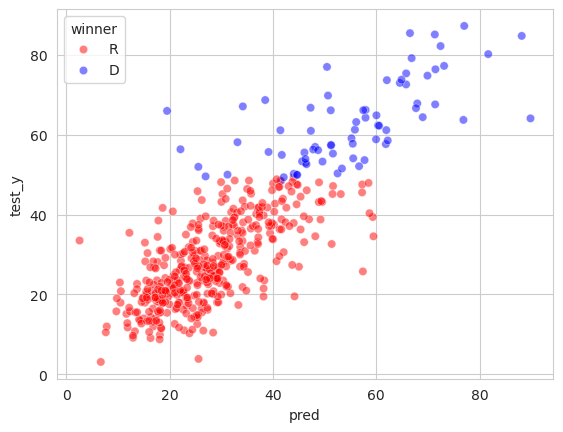

In [67]:
#Example chart
pred=pd.DataFrame({'pred':model.predict(test_var[features]).flatten(),'test_y':test_var['democrat'].values,'winner':test_var['winner'].values})
sns.scatterplot(data=pred,x='pred',y='test_y',hue='winner',palette=['red','blue'], alpha=0.5)
plt.show()